In [2]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [49]:
#Plot the graph
def plotGraph(G,edgeDivisor=200.0,nodeDivisor=1.5,edgeFlag=True,nodeFlag=True,edgeWeight='weight'):
    '''
    Plot a graph where the positions of the nodes are specified
    in the name of the node, aka a tuple (x,y) is the node name'''
    pos = {node:node for node in G.nodes()}
    px = [p[0] for p in pos]
    py = [p[1] for p in pos]
    edges = G.edges()
    if edgeFlag==True:
        weights = [G[u][v][edgeWeight]/float(edgeDivisor) for u,v in edges] #divide by 4 for scale in graphing
    else:
        weights = [1 for _ in edges]
    if nodeFlag==True:
        sizes = G.degree().values()
        sizes = [float(s)/nodeDivisor if float(s)/nodeDivisor>7 else 7 for s in sizes]
    else:
        sizes = [7 for _ in G.nodes()]
    
    fig=plt.figure(figsize=(8, 16))
    plt.axis('equal')
    nx.draw(G, pos, edges=edges, width=weights, node_size=sizes)
    #nx.draw_networkx_labels(G,pos)
    plt.show()

In [25]:
#Use this to make a sample graph if necessary - probably not necessary anymore
if False:    
    #Create a test graph
    A = nx.Graph()
    for i in range(3):
        for j in range(3):
            A.add_node((i,j), pos=(i,j))
    #Add some edges
    A.add_edge((0,0),(1,0),weight=5)
    A.add_edge((0,0),(1,0),weight=2)
    A.add_edge((0,0),(1,2),weight=4)
    A.add_edge((0,0),(2,2),weight=4)
    A.add_edge((1,0),(0,2),weight=5)
    A.add_edge((1,0),(2,1),weight=2)
    A.add_edge((2,0),(0,1),weight=3)
    A.add_edge((2,0),(2,1),weight=1)
    A.add_edge((1,1),(2,1),weight=3)
    A.add_edge((1,1),(2,2),weight=6)
    A.add_edge((2,1),(2,2),weight=2)
    A.add_edge((0,2),(1,2),weight=3)
    
    #Plot the graph
    G = A
    pos=nx.get_node_attributes(G,'pos')
    edges = G.edges()
    weights = [G[u][v]['weight']*2 for u,v in edges] #divide by 4 for scale in graphing
    nx.draw(G, pos, edges=edges, width=weights, node_size=1000)
    nx.draw_networkx_labels(G,pos,)
    plt.show()

In [26]:
#Load the adjacency matrix
with open('rushhr_adjacencymatrix.pickle', 'rb') as handle:
    A = pickle.load(handle)
print(A.nodes()[0:10])

[(7, 3), (3, 35), (6, 28), (4, 36), (7, 25), (8, 5), (13, 32), (9, 0), (10, 7), (11, 22)]


[((7, 3), (7, 4)), ((7, 3), (6, 3)), ((7, 3), (8, 3)), ((7, 3), (7, 2)), ((3, 35), (2, 35)), ((3, 35), (3, 34)), ((3, 35), (3, 36)), ((3, 35), (4, 35)), ((6, 28), (7, 28)), ((4, 36), (4, 37))]


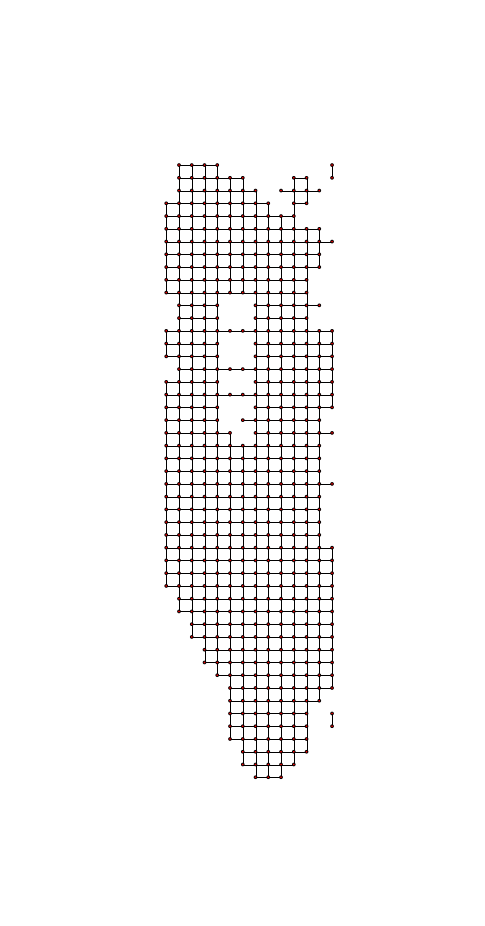

In [27]:
#Create a path graph - P
P = nx.Graph()
P.add_nodes_from(A.nodes())
allnodes = P.nodes()
for node in allnodes:
    #Add a node up if it is avaliable
    upnode = (node[0],node[1]+1)
    if upnode in allnodes:
        P.add_edge(node,upnode)
    rightnode = (node[0]+1,node[1])
    #Add a node to the right if it is avaliable
    if rightnode in allnodes:
        P.add_edge(node,rightnode)
print(P.edges()[0:10])
#Plot the path graph
plotGraph(P,edgeFlag=False,nodeFlag=False)

In [36]:
#Create a BiPartite Graph
#Delete the previous graph if it exists
if 'B' in locals():
    del B
B = nx.Graph()
#Add nodes
B.add_nodes_from(A.nodes(data=True),bipartite=0)
#Cycle through the edges of the adjacency matrix and add them as edges to the bipartie graph
for edge in A.edges(data=True):
    #Get the start and the end point of the edge
    startNode = edge[0]
    endNode = edge[1]
    path = nx.shortest_path(P,startNode,endNode)
    #See if the path is long enough to be counted
    if len(path) > 2:
        #Add a node to the bipartie graph for the path
        B.add_node((startNode,endNode),bipartite=1)
        #Iterate through each node that is passed through
        for passedNode in path[1:-1]:
            #Add an edge on the graph, potentially adding new nodes
            B.add_edge((startNode,endNode), passedNode, weight=edge[2]['weight'])

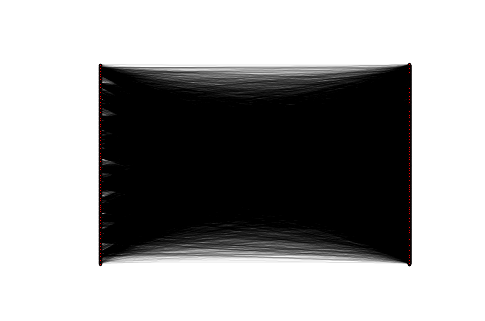

In [40]:
#Display the bipartite graph visually
#NOTE THAT THIS TAKES A REALLY LONG TIME
G=B
#Create sets of each node type in the graph
X = set(node[0] for node in G.nodes(data=True) if node[1]['bipartite']==0)
Y = set(node[0] for node in G.nodes(data=True) if node[1]['bipartite']==1)

#Create positions for each in the set
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
yscale = float(len(X))/len(Y) #Scale for graphic purposes
pos.update( (n, (2, i*yscale)) for i, n in enumerate(Y) ) # put nodes from Y at x=2

edges = G.edges()
weights = [G[u][v]['weight']/200.0 for u,v in edges] #divide by 4 for scale in graphing
nx.draw(G, pos=pos, edges=edges, width=weights, node_size=5)
#nx.draw_networkx_labels(G,pos=pos)
plt.show()

In [ ]:
#Add info on O/D totals and passing through totals
for node in A.nodes(data=True):
    #Determine the number of edges that pass through each node, save to the adjacency graph - A
    node[1]['totalThrough'] = B.degree(node[0],weight='weight')
    #Determine the number of O/D that end up on a particular node
    node[1]['totalOD'] = A.degree(node[0],weight='weight')

    
#Display the graph of how many people pass through each node
pos = {node:node for node in G.nodes()}
px = [p[0] for p in pos]
py = [p[1] for p in pos]

nodeDivisor = 70
sizes = [float(node[1]['totalThrough'])/nodeDivisor \
         if float(node[1]['totalThrough'])/nodeDivisor>7 \
         else 7 for node in A.nodes(data=True)]

fig=plt.figure(figsize=(8, 16))
plt.axis('equal')
nx.draw(G)#, pos, node_size=sizes)
#nx.draw_networkx_labels(G,pos)
plt.show()